# Setup

In [1]:
# Extract and build the benchmark
!rm -f ipc/ipc-static
!rm -f ipc/ipc-dynamic
!make -C ipc
!sysctl kern.ipc.maxsockbuf=33554432

cc -DWITH_PMC -Wall -o ipc-static -DPROGNAME=\"ipc-static\" ipc.c -static  -lpmc -lpthread
cc -DWITH_PMC -Wall -o ipc-dynamic -DPROGNAME=\"ipc-dynamic\" ipc.c -dynamic  -lpmc -lpthread
cc -DWITH_PMC -Wall -o ipc-static-nonblock -DPROGNAME=\"ipc-static-nonblock\" ipc-nonblock.c -static  -lpmc -lpthread
ipc-nonblock.c:503:16: warning: unused variable 'bytes_to_write' [-Wunused-variable]
                const size_t bytes_to_write = min(buffersize, totalsize - write_sofar);
                             ^
1 warning generated.
kern.ipc.maxsockbuf: 2097152 -> 33554432


In [9]:
import itertools
import re

def strs_to_tup(strs):
    if len(strs) == 1:
        return (strs[0].strip(),None)
    else:
        return (strs[0].strip(),strs[1].strip())

def flatten(lst):
    return list(itertools.chain.from_iterable(lst))

def parse(cmd_out):
    tups = map(strs_to_tup, [string.split(":") for string in cmd_out])
    return dict(tups)

def genfilename(exe, mode, ipc, runs, flags, suffix="", extension = "png"):
    return "{}_{}_{}_runs_{}_{}{}.{}".format(re.sub(r'[/-]', r'_', exe), mode, ipc, runs, re.sub(r'\s*-', r'', flags), suffix, extension)

def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z

def gather_pmc_vals(table, data, pmc):
    if pmc == "mem":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['mem_read'] = [float(item["MEM_READ"]) for item in data]
        table['mem_read_per_cycle'] = [float(item["MEM_READ/CLOCK_CYCLES"]) for item in data]
        table['mem_read_per_instr'] = [float(item["MEM_READ/INSTR_EXECUTED"]) for item in data]
        table['mem_write'] = [float(item["MEM_WRITE"]) for item in data]
        table['mem_write_per_cycle'] = [float(item["MEM_WRITE/CLOCK_CYCLES"]) for item in data]
        table['mem_write_per_instr'] = [float(item["MEM_WRITE/INSTR_EXECUTED"]) for item in data]
    elif pmc == "l1d":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['l1d_hits'] = [float(item["L1_DCACHE_ACCESS"]) for item in data]
        table['l1d_hits_per_instr'] = [float(item["L1_DCACHE_ACCESS/INSTR_EXECUTED"]) for item in data]
        table['l1d_hits_per_cycle'] = [float(item["L1_DCACHE_ACCESS/CLOCK_CYCLES"]) for item in data]
        table['l1d_refill'] = [float(item["L1_DCACHE_REFILL"]) for item in data]
        table['l1d_refill_per_instr'] = [float(item["L1_DCACHE_REFILL/INSTR_EXECUTED"]) for item in data]
        table['l1d_refill_per_cycle'] = [float(item["L1_DCACHE_REFILL/CLOCK_CYCLES"]) for item in data]
    elif pmc == "l1i":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['l1i_refill'] = [float(item["L1_ICACHE_REFILL"]) for item in data]
        table['l1i_refill_per_instr'] = [float(item["L1_ICACHE_REFILL/INSTR_EXECUTED"]) for item in data]
        table['l1i_refill_per_cycle'] = [float(item["L1_ICACHE_REFILL/CLOCK_CYCLES"]) for item in data]
    elif pmc == "l2":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['l2_hit'] = [float(item["L2_ACCESS"]) for item in data]
        table['l2_hit_per_instr'] = [float(item["L2_ACCESS/INSTR_EXECUTED"]) for item in data]
        table['l2_hit_per_cycle'] = [float(item["L2_ACCESS/CLOCK_CYCLES"]) for item in data]
    elif pmc == "axi":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['axi_read'] = [float(item["AXI_READ"]) for item in data]
        table['axi_read_per_instr'] = [float(item["AXI_READ/INSTR_EXECUTED"]) for item in data]
        table['axi_read_per_cycle'] = [float(item["AXI_READ/CLOCK_CYCLES"]) for item in data]
        table['axi_write'] = [float(item["AXI_WRITE"]) for item in data]
        table['axi_write_per_instr'] = [float(item["AXI_WRITE/INSTR_EXECUTED"]) for item in data]
        table['axi_write_per_cycle'] = [float(item["AXI_WRITE/CLOCK_CYCLES"]) for item in data]
    elif pmc == "tlb":
        table['instrs'] = [float(item["INSTR_EXECUTED"]) for item in data]
        table['cycles'] = [float(item["CLOCK_CYCLES"]) for item in data]
        table['cycles_per_instr'] = [float(item["CLOCK_CYCLES/INSTR_EXECUTED"]) for item in data]
        table['itlb_refill'] = [float(item["ITLB_REFILL"]) for item in data]
        table['itlb_refill_per_instr'] = [float(item["ITLB_REFILL/INSTR_EXECUTED"]) for item in data]
        table['itlb_refill_per_cycle'] = [float(item["ITLB_REFILL/CLOCK_CYCLES"]) for item in data]
        table['dtlb_refill'] = [float(item["DTLB_REFILL"]) for item in data]
        table['dtlb_refill_per_instr'] = [float(item["DTLB_REFILL/INSTR_EXECUTED"]) for item in data]
        table['dtlb_refill_per_cycle'] = [float(item["DTLB_REFILL/CLOCK_CYCLES"]) for item in data]
    else:
        raise ValueError("Wrong pmc type: {}".format(pmc))
    return table

print("Done with PMC setup")

Done with PMC setup


In [10]:
import time
from __future__ import print_function
from decimal import Decimal
import pandas as pd
import numpy as np
%matplotlib inline
# import matplotlib.pyplot as plt
#import matplotlib.style
import matplotlib as mpl
#mpl.style.use('classic')
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

def label_points(x, y, ax):
    a = pd.concat({'x': x, 'y': y}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], "{:.2E}".format(Decimal(point['x'])))

def graph(xs, ys, num_trials = 0, save = False, save_name = None, texty = 100, ylog = False, title = None, xlabel = None, ylabel = None, label = '_nolegend_', axis = None):
    # plt.style.use('seaborn-whitegrid')
    xvalues = np.reshape(ys, (len(xs), num_trials))[:,:]
    df = pd.DataFrame(xvalues, index=xs)
    error_bars = df.quantile([.25, .75], axis=1)
    error_bars.loc[[0.25]] = df.median(1) - error_bars.loc[[0.25]]
    error_bars.loc[[0.75]] = error_bars.loc[[0.75]] - df.median(1)
    error_bars_values = [error_bars.values]
    if axis is not None:
        ax = df.median(1).plot(yerr=error_bars_values, title=title, ax=axis, label = label)
    else:
        fig = plt.figure(figsize=(18,6))
        ax = df.median(1).plot(yerr=error_bars_values, title=title, label = label)

    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if label:
        ax.set_label(label)
    if title:
        ax.set_title(title)
    if ylog:
        ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xticks(df.index)
    ax.set_xticklabels(xs, rotation=45)
    plt.grid('on', axis='x' )
    plt.grid('on', axis='y' )
    plt.legend()
    if save_name is not None:
        ax.get_figure().savefig("{}".format(save_name))
    return ax

def benchmark(flags, repeat, exe, mode, ipc, buf_sizes, tot_sizes, dtrace_info = None, bench_name = "", pmc = None, quiet = False):
    runs = range(1, repeat + 1)
    outputs = []
    if not quiet:
        print("\t ==> Running {}".format(exe))
        print("\t\t ==> {} across {}".format(ipc, mode))
    is_dtrace = (dtrace_info != None)
    if is_dtrace and not quiet:
        print("\t\t ==> Running in DTrace mode")
    dtrace_thread = None
    verbose = "-v" in flags
    pmc_enabled = pmc is not None

    for buffer_size in buf_sizes:
        for tot_size in tot_sizes:
            cmd = "{} {} -i {} -b {} -t {} {}".format(exe, flags, ipc, buffer_size, tot_size, mode)

            discard = !{cmd} # Discard first benchmark run which may be biased
            if is_dtrace:
                dtraceSleep = dtrace_info['sleep'] if 'sleep' in dtrace_info else 1
                # Create a seperate thread to run the DTrace instrumentation
                dtrace_thread = DTraceConsumerThread(dtrace_info['script'],
                                                        chew_func=None,
                                                        chewrec_func=None,
                                                        walk_func=dtrace_info['agg_fn'],
                                                        sleep=dtraceSleep)
                # Start the DTrace instrumentation
                dtrace_thread.start()

            results = []
            for i in runs:
                out = !{cmd}
                parsed = parse(out)
                results.append(parsed)

            if is_dtrace and dtrace_thread != None:
                # The benchmark has completed - stop the DTrace instrumentation
                dtrace_thread.stop()
                dtrace_thread.join()
                dtrace_thread.consumer.__del__() # Memory leak workaround

            times = [float(item['time']) for item in results] if verbose else None
            avg_time = sum(times) / len(runs) if verbose else None

            speeds = [float(item['speed'].split(' ')[0]) for item in results] # Need to split by ' ' because output speed has units attached to it (see ipc.c)
            avg_speed = sum(speeds) / len(runs)
            if not quiet:
                print("\t\t\t{0:2} bytes {1:2} bytes: {2:.2f} KBytes/sec".format(buffer_size, tot_size, avg_speed))
            res = {'buffersize':buffer_size, 'time':avg_time, 'speed':avg_speed, 'tot_sz':tot_size, 'speeds': speeds, 'times': times}
            if pmc_enabled:
                pmc_data = gather_pmc_vals({}, results, pmc)

                avgs = {}
                for key,val in pmc_data.iteritems():
                    avg_key = "avg_" + key
                    avgs[avg_key] = sum(val) / len(runs)

                pmc_data['pmctype'] = results[0]["pmctype"]
                # Merge dictionaries
                pmc_data = merge_two_dicts(avgs, pmc_data)
                res = merge_two_dicts(res, pmc_data)
            outputs.append(res)
    return outputs

def highlight(axis, texty = 100):
    axis.axvspan(0, 8192, alpha=0.15, color='r')
    axis.axvspan(8193, 32768, alpha=0.15, color='g')
    axis.axvspan(32769, 65536, alpha=0.15, color='m')
    axis.axvspan(65537, 131072, alpha=0.15, color='c')
    axis.axvspan(131073, 262144, alpha=0.15, color='y')
    axis.text(3500, texty, "4K Page Size")
    axis.text(12000, texty, "16K PIPE_SIZE")
    axis.text(30000, texty, "32K L1")
    axis.text(90000, texty, "32x4K TLB entries")
    axis.text(250000, texty, "256K L2")

print("Set up completed")

Set up completed


In [5]:
def graph_pmc(ipcs, mode, pmc, props, dtrace_info = None, axis = None):
    FLAGS="-P {}".format(pmc)
    res = {}
    for obj in ipcs:
        tmpFlags = FLAGS + " -s" if obj == "match" else FLAGS
        tmpObj = "local" if obj == "match" else obj
        res[obj] = benchmark(tmpFlags, RUNS, EXE, mode, tmpObj, BUFFER_SIZES, TOT_SIZES, pmc = pmc, dtrace_info = dtrace_info)

    for p in props:
        ax = axis
        for obj in ipcs:
            label = "local (matching buffer size)" if obj == "match" else obj
            saveas = None if obj != ipcs[-1] else genfilename(EXE, mode, "all", RUNS, FLAGS, suffix = "pmc_" + p)
            pickle_name = genfilename(EXE, mode, "all", RUNS, FLAGS, suffix = "pmc_" + p, extension = ".pkl")
            pd.to_pickle(res[obj], pickle_name)
            ax = graph(BUFFER_SIZES, flatten([item[p] for item in res[obj]]),
                        RUNS, label=label, axis = ax,
                            title = "PMC {} on {} Across Varying IPC Buffer Sizes".format(p, mode),
                              xlabel = "Buffer Size (Bytes)", ylabel=p, save_name = saveas)
    return ax


def graph_mc_pmc(ipc, modes, pmc, props, axis = None):
    FLAGS="-P {}".format(pmc)
    FLAGS += " -s" if ipc == "match" else ""
    ipcObj = "local" if ipc == "match" else ipc
    ipcLabel = "local (matching buffer size)" if ipc == "match" else ipc
    res = {}
    for mode in modes:
        res[mode] = benchmark(FLAGS, RUNS, EXE, mode, ipcObj, BUFFER_SIZES, TOT_SIZES, pmc = pmc)

    for p in props:
        ax = axis
        for mode in modes:
            saveas = None if mode != modes[-1] else genfilename(EXE, mode, ipcObj, RUNS, FLAGS, suffix = "mc_pmc_" + p)
            pickle_name = genfilename(EXE, mode, ipcObj, RUNS, FLAGS, suffix = "mc_pmc_" + p, extension = ".pkl")
            pd.to_pickle(res[mode], pickle_name)
            ax = graph(BUFFER_SIZES, flatten([item[p] for item in res[mode]]),
                        RUNS, label=mode, axis = ax,
                            title = "PMC {} vs. IPC Buffer Sizes on 1thread/2thread/2proc for {}".format(p, ipcLabel),
                              xlabel = "Buffer Size (Bytes)", ylabel=p, save_name = saveas)
    return ax

In [4]:
def calc_bw(data):
    sortedKeys = data.keys()
    sortedKeys.sort()
    for buf in sortedKeys:
        ns = float(data[buf]['vtime']) / float(1e9)
        print(str((buf / 1024) / ns) + " KB/sec.")

def process_rw_pairs(data):
    sortedKeys = data.keys()
    sortedKeys.sort()
    reads = []
    writes = []
    read_ratios = {}
    write_ratios = {}
    for buf in sortedKeys:
        reads.append([(tup[0][1], tup[0][2], tup[1], buf) for tup in data[buf] if tup[0][0] == 'read'])
        writes.append([(tup[0][1], tup[0][2], tup[1], buf) for tup in data[buf] if tup[0][0] == 'write'])
    for bufArr in reads:
        for tup in bufArr:
            ratio = float(tup[1]) / float(tup[0]) if tup[1] > 0 else tup[1]
            sz = tup[3]
            if sz in read_ratios:
                read_ratios[sz] += [ratio] * tup[2]
            else:
                read_ratios[sz] = [ratio] * tup[2]
    for bufArr in writes:
        for tup in bufArr:
            ratio = float(tup[1]) / float(tup[0]) if tup[1] > 0 else tup[1]
            sz = tup[3]
            if sz in write_ratios:
                write_ratios[sz] += [ratio] * tup[2]
            else:
                write_ratios[sz] = [ratio] * tup[2]
    return {'reads' : read_ratios,
             'writes': write_ratios}

def graph_rw_pairs(pairs, key, title="", xlabel="", ylabel="Frequency", saveas = None):
    frames = []
    sortedKeys = pairs[key].keys()
    sortedKeys.sort()
    for sz in sortedKeys:
        frames.append(pd.DataFrame(pairs[key][sz], columns = [sz]))
    df = pd.concat(frames, axis=1)
    ax = df.plot(kind='hist', bins=50, log=True, stacked=True, figsize=(20,10), title=title)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    if saveas is not None:
        ax.get_figure().savefig("{}".format(saveas))

# Callbacks invoked to process the aggregation
def test_agg(a, b, c, d):
    values = {}
    print("From DTrace: {} | {} | {} | val: {}".format(a,b,c,d))

def simple_agg(a, b, c, d):
    values.append(d)

def acc_agg(a, b, c, d):
    if c[0] not in values:
        values[c[0]] = [d]
    else:
        values[c[0]].append(d)

def map_agg(a, b, c, d):
    if len(c):
        values[c[0]] = d

def pair_agg(a, b, c, d):
    values.append((c, d))

def quantized_agg(a, b, c, d):
    dist = d
    filtered = [tup if tup[0][0] >= -2 and tup[0][0] <= BUFFER_SIZES[-1] else None for tup in dist]
    filtered = [x for x in filtered if x is not None ]
    values[c[0]] = filtered

def dummy_agg(a, b, c, d):
    pass

## 2thread

	 ==> Running ipc/ipc-static
		 ==> pipe across 2thread
			2048 bytes 16777216 bytes: 173781.54 KBytes/sec
			4096 bytes 16777216 bytes: 238737.09 KBytes/sec
			8192 bytes 16777216 bytes: 276813.72 KBytes/sec
			16384 bytes 16777216 bytes: 389215.41 KBytes/sec
			32768 bytes 16777216 bytes: 494210.18 KBytes/sec
			65536 bytes 16777216 bytes: 554708.82 KBytes/sec
			131072 bytes 16777216 bytes: 312979.26 KBytes/sec
			262144 bytes 16777216 bytes: 169148.27 KBytes/sec
			524288 bytes 16777216 bytes: 157736.07 KBytes/sec
			1048576 bytes 16777216 bytes: 154179.30 KBytes/sec
			2097152 bytes 16777216 bytes: 148407.87 KBytes/sec
			4194304 bytes 16777216 bytes: 140160.90 KBytes/sec
			8388608 bytes 16777216 bytes: 127081.90 KBytes/sec
			16777216 bytes 16777216 bytes: 106398.66 KBytes/sec


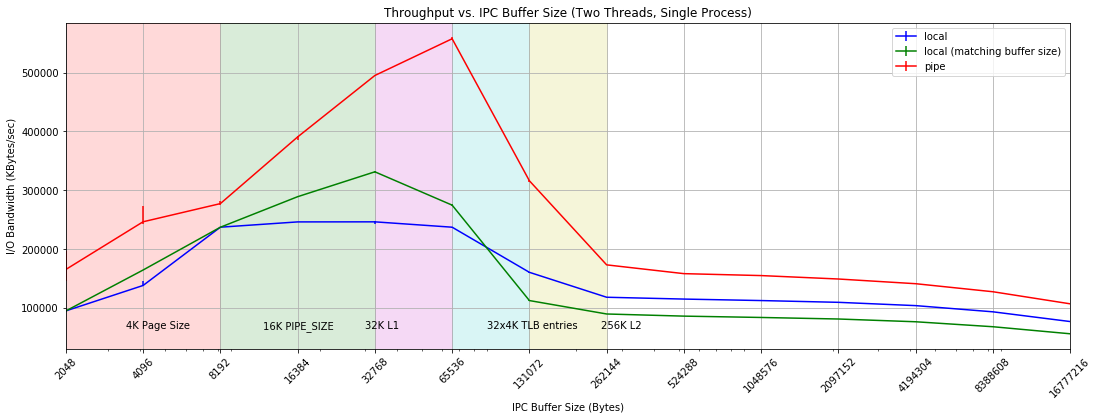

In [6]:
BUF_START = 512
#BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(8, 16)] # Start from 128KB
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(2, 16)]
TOT_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
EXE="ipc/ipc-static"
FLAGS=""

MODE = "2thread"
IPC= "local"
#local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(local, "./local_2thread.pkl")
local = pd.read_pickle("pkls/local_2thread.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS,
            xlabel='IPC Buffer Size (Bytes)', ylabel='I/O Bandwidth (KBytes/sec)',
              label=IPC, title = "Throughput vs. IPC Buffer Size (Two Threads, Single Process)")

FLAGS="-s"
#local = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(local, "./local_s_2thread.pkl")
local = pd.read_pickle("pkls/local_s_2thread.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in local]), RUNS,
          label=IPC + " (matching buffer size)", axis = p)

FLAGS=""
IPC= "pipe"
#pipe = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)
#pd.to_pickle(pipe, "./pipe_2thread.pkl")
pipe = pd.read_pickle("pkls/pipe_2thread.pkl")
highlight(p, texty = 65000)
saveas = genfilename(EXE, MODE, "all", RUNS, FLAGS, suffix = "vary_buffer")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in pipe]), RUNS, axis = p, label=IPC, save = True, save_name = saveas)

# DTrace

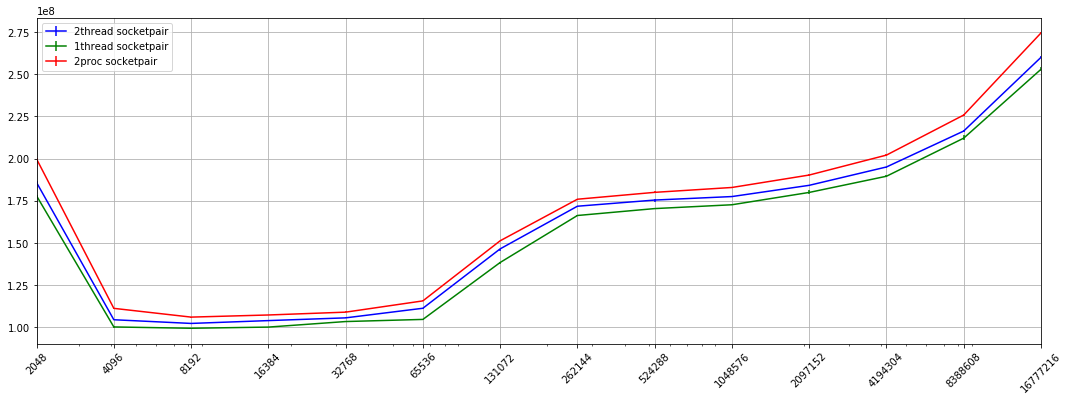

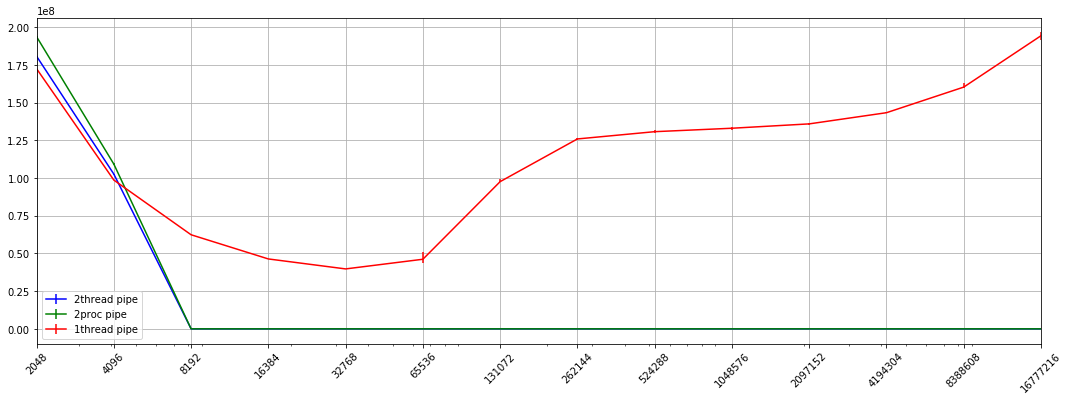

In [6]:
data = {'2thread_fault':[], '2proc_fault':[],
        '2thread_phys':[], '2proc_phys':[],
        '1thread_fault_pipe':[],'1thread_fault_local':[]
       }
RUNS = 10
FLAGS = ""
EXE = "ipc-static"
BUFFER_SIZES = [512 * 2 ** exp for exp in range(2, 16)]
for sz in BUFFER_SIZES:
    text_file = open("data/uio.out_{}_local_{}".format("2thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "fault" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2thread_fault"] += nums
    text_file = open("data/uio.out_{}_local_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "fault" in l]
    nums = [int(n) for n in lines if n is not '']
    data["2proc_fault"] += nums
    text_file = open("data/uio.out_{}_pipe_{}".format("2thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "fault" in l] # TODO: add faultflag time?
    if len(lines) is not RUNS:
        lines += [0] * (RUNS - len(lines))
    nums = [int(n) for n in lines if n is not '']
    data["2thread_phys"] += nums
    text_file = open("data/uio.out_{}_pipe_{}".format("2proc", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "fault" in l]
    if len(lines) is not RUNS:
        lines += [0] * (RUNS - len(lines))
    nums = [int(n) for n in lines if n is not '']
    data["2proc_phys"] += nums

    text_file = open("data/uio.out_{}_local_{}".format("1thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "fault" in l]
    if len(lines) is not RUNS:
        lines += [0] * (RUNS - len(lines))
    nums = [int(n) for n in lines if n is not '']
    data["1thread_fault_local"] += nums
    text_file = open("data/uio.out_{}_pipe_{}".format("1thread", sz), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split()[1] for l in lines if "fault" in l]
    if len(lines) is not RUNS:
        lines += [0] * (RUNS - len(lines))
    nums = [int(n) for n in lines if n is not '']
    data["1thread_fault_pipe"] += nums

p = graph(BUFFER_SIZES,data['2thread_fault'], RUNS, label="2thread socketpair")
p = graph(BUFFER_SIZES,data['1thread_fault_local'], RUNS, label="1thread socketpair", axis = p)
p = graph(BUFFER_SIZES,data['2proc_fault'], RUNS, label="2proc socketpair", axis = p)
# Pipes
p = graph(BUFFER_SIZES,data['2thread_phys'], RUNS, label="2thread pipe")
p = graph(BUFFER_SIZES,data['2proc_phys'], RUNS, label="2proc pipe", axis = p)
p = graph(BUFFER_SIZES,data['1thread_fault_pipe'], RUNS, label="1thread pipe", axis = p)

## Probe Effect

### Effect of DTrace

	 ==> Running ipc/ipc-static
		 ==> pipe across 2proc
		 ==> Running in DTrace mode
			2048 bytes 16777216 bytes: 93461.22 KBytes/sec
			4096 bytes 16777216 bytes: 149069.55 KBytes/sec
			8192 bytes 16777216 bytes: 111833.93 KBytes/sec
			16384 bytes 16777216 bytes: 189128.87 KBytes/sec
			32768 bytes 16777216 bytes: 284653.27 KBytes/sec
			65536 bytes 16777216 bytes: 336256.73 KBytes/sec
			131072 bytes 16777216 bytes: 193147.02 KBytes/sec
			262144 bytes 16777216 bytes: 136795.75 KBytes/sec
			524288 bytes 16777216 bytes: 128384.02 KBytes/sec
			1048576 bytes 16777216 bytes: 128309.15 KBytes/sec
			2097152 bytes 16777216 bytes: 122294.76 KBytes/sec
			4194304 bytes 16777216 bytes: 115358.76 KBytes/sec
			8388608 bytes 16777216 bytes: 104274.26 KBytes/sec
			16777216 bytes 16777216 bytes: 86836.83 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> pipe across 1thread
		 ==> Running in DTrace mode
			2048 bytes 16777216 bytes: 245922.67 KBytes/sec
			4096 bytes 16777216 bytes: 361921.28 KB

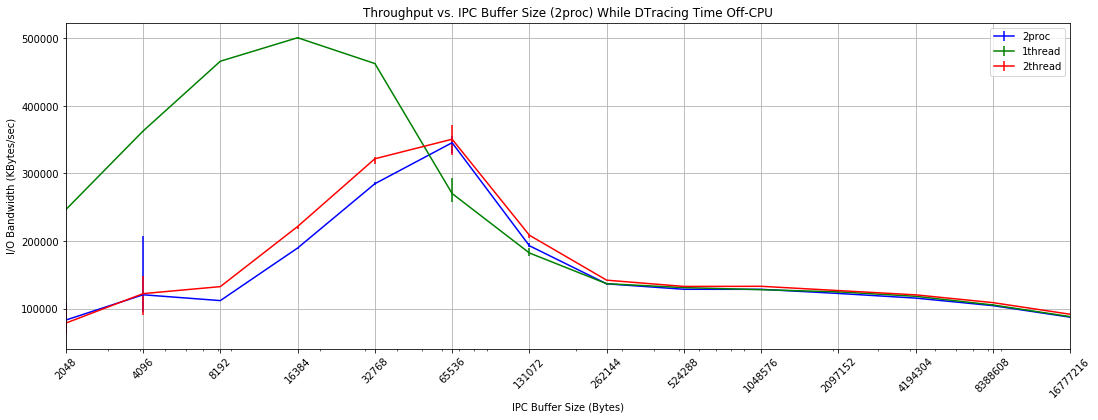

In [22]:
MODE="2proc"
IPC= "pipe"
proc2 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, dtrace_info = {'agg_fn':dummy_agg, 'script':D_off_cpu})
pd.to_pickle(proc2, "pkls/pipe_2proc_probe_off_cpu.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in proc2]), RUNS, xlabel='IPC Buffer Size (Bytes)',
            ylabel='I/O Bandwidth (KBytes/sec)', label=MODE,
                title = "Throughput vs. IPC Buffer Size (2proc) While DTracing Time Off-CPU")

MODE="1thread"
thread1 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, dtrace_info = {'agg_fn':dummy_agg, 'script':D_off_cpu})
pd.to_pickle(thread1, "pkls/pipe_1thread_probe_off_cpu.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in thread1]), RUNS, axis = p, label=MODE)

MODE="2thread"
thread2 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES, dtrace_info = {'agg_fn':dummy_agg, 'script':D_off_cpu})
pd.to_pickle(thread2, "pkls/pipe_2thread_probe_off_cpu.pkl")
saveas = genfilename(EXE, MODE, "all", RUNS, FLAGS, suffix = "probe_effect_dtrace_off_cpu")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in thread2]), RUNS, axis = p, label=MODE, save = True,
          save_name = saveas)

# Statistical Analysis

* do null hypothesis test on mean for thread models for pipe vs local; do null hypothesis test on local with and without matching buffers
* median test using scipy->run 10 and 20 runs of benchmark for hypothesis tests->plot p-value as buffer size increases
* test for statistical difference in matching vs. non-matching socketpairs
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_test.html
* https://www.itl.nist.gov/div898/software/dataplot/refman1/auxillar/meditest.htm
* https://en.wikipedia.org/wiki/Median_test
* https://www.cl.cam.ac.uk/teaching/1819/L41/notes/2018-2019-l41-lab-1-io-notes.pdf

# Notes

* https://www.cl.cam.ac.uk/teaching/1819/L41/2018-2019-l41-lecturelet4-lab-tcp-p1-handout.pdf
* RFC 793: https://tools.ietf.org/html/rfc793
* RFC 893: https://tools.ietf.org/html/rfc893
* dtrace -n 'fbt::tcp_do_segment:entry/ntohs(args[3]->t_inpcb->inp_inc.inc_ie.ie_lport) == 10141 || ntohs(args[3]->t_inpcb->inp_inc.inc_ie.ie_fport) == 10141/ { trace((unsigned int)args[1]->th_seq); trace((unsigned int)args[1]->th_ack); trace(tcp_state_string[args[3]->t_state]);}'
  * state-syn-sent
  * state-syn-received
  * state-established
  * state-fin-wait-1
  * state-fin-wait-2
  * state-last-ack
* For state transitions:
  * dtrace -n 'fbt::tcp_state_change:entry/ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_lport) == 10141 || ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_fport) == 10141/ {   trace(ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_lport));  trace(ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_fport));  trace(tcp_state_string[args[0]->t_state]);  trace(tcp_state_string[args[1]]); }'